# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [13]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [14]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [15]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Optimal Separation Size For Individual Features
Here we will use a constant window size of 7 days, but increase the x and y separation up to 43 days (7 + 43 = 50 day max window)

In [21]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
separations = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_sep = dict()

max_iter = 25000
loss = "log"

current_x_window = pd.Timedelta('7 days') # This remains constant for this test
while current_x_window + current_separation <= max_x_window:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    separations.append(current_separation)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window + current_separation <= max_x_window_size_for_use:
                print("Updating best accuracy and shift size.")
                best_accuracies[col] = accuracy
                best_sep[col] = current_separation
        accuracies[col].append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7283582089552239
recall 0.8170731707317073
precision 0.7579185520361991

Updating best accuracy and shift size.
Training model on: pH (mV)
accuracy 0.608955223880597
recall 0.9926829268292683
precision 0.6111111111111112

Updating best accuracy and shift size.
Training model on: ODOSat%
accuracy 0.6895522388059702
recall 0.5365853658536586
precision 0.9243697478991597

Updating best accuracy and shift size.
Training model on: TMAX
accuracy 0.564179104477612
recall 0.4951219512

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Wind Speed
accuracy 0.582089552238806
recall 0.4024390243902439
precision 0.825

Updating best accuracy and shift size.
Training model on: TMIN
accuracy 0.6746268656716418
recall 0.5390243902439025
precision 0.884

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.47313432835820896
recall 0.18048780487804877
precision 0.8131868131868132

Updating best accuracy and shift size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Temp C
accuracy 0.6283582089552239
recall 0.44634146341463415
precision 0.8926829268292683

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.6686567164179105
recall 0.5560975609756098
precision 0.8507462686567164

Updating best accuracy and shift size.
Training model on: Sp Cond (uS/cm)
accuracy 0.3641791044776119
recall 0.012195121951219513
precision 0.19230769230769232

Updating best accuracy and shift size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Updating best accuracy and shift size.
current separation 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7192192192192193
recall 0.8145363408521303
precision 0.7420091324200914

Training model on: pH (mV)
accuracy 0.5915915915915916
recall 0.9874686716791979
precision 0.5960665658093798

Training model on: ODOSat%
accuracy 0.7042042042042042
recall 0.5513784461152882
precision 0.9243697478991597

Updating best accuracy and shift size.
Training model on: TMAX
accuracy 0.575075075075075
rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Wind Speed
accuracy 0.5840840840840841
recall 0.40100250626566414
precision 0.8080808080808081

Updating best accuracy and shift size.
Training model on: TMIN
accuracy 0.6981981981981982
recall 0.5614035087719298
precision 0.896

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.46396396396396394
recall 0.14536340852130325
precision 0.7837837837837838

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Temp C
accuracy 0.6381381381381381
recall 0.46365914786967416
precision 0.8726415094339622

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.6816816816816816
recall 0.5664160401002506
precision 0.8528301886792453

Updating best accuracy and shift size.
Training model on: Sp Cond (uS/cm)
accuracy 0.35435435435435436
recall 0.012531328320802004
precision 0.12195121951219512

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Updating best accuracy and shift size.
current separation 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7054380664652568
recall 0.8120300751879699
precision 0.7297297297297297

Training model on: pH (mV)
accuracy 0.5966767371601208
recall 0.9899749373433584
precision 0.6003039513677811

Training model on: ODOSat%
accuracy 0.7129909365558912
recall 0.5614035087719298
precision 0.9372384937238494

Updating best accuracy and shift size.
Training model on: TMAX
accuracy 0.5996978851963746
re

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5785498489425982
recall 0.40852130325814534
precision 0.7912621359223301

Training model on: TMIN
accuracy 0.6993957703927492
recall 0.5639097744360902
precision 0.9

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.46676737160120846
recall 0.17042606516290726
precision 0.7555555555555555

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40634441087613293
recall 0.022556390977443608
precision 0.75

Updating best accuracy and shift size.
Training model on: Temp C
accuracy 0.649546827794562
recall 0.47869674185463656
precision 0.8883720930232558

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.6812688821752266
recall 0.5664160401002506
precision 0.8560606060606061

Training model on: Sp Cond (uS/cm)
accuracy 0.3217522658610272
recall 0.010025062656641603
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

current separation 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7196969696969697
recall 0.8074074074074075
precision 0.7534562211981567

Training model on: pH (mV)
accuracy 0.6075757575757575
recall 0.9901234567901235
precision 0.6112804878048781

Training model on: ODOSat%
accuracy 0.703030303030303
recall 0.5456790123456791
precision 0.9484978540772532

Training model on: TMAX
accuracy 0.5924242424242424
recall 0.5234567901234568
precision 0.7361111111111112

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5636363636363636
recall 0.3950617283950617
precision 0.7881773399014779

Training model on: TMIN
accuracy 0.6924242424242424
recall 0.5580246913580247
precision 0.904

Training model on: Wind Angle
accuracy 0.4590909090909091
recall 0.17037037037037037
precision 0.7666666666666667

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.39545454545454545
recall 0.037037037037037035
precision 0.625

Training model on: Temp C
accuracy 0.6409090909090909
recall 0.4691358024691358
precision 0.8962264150943396

Training model on: ODO (mg/L)
accuracy 0.6621212121212121
recall 0.5481481481481482
precision 0.8473282442748091

Training model on: Sp Cond (uS/cm)
accuracy 0.3090909090909091
recall 0.009876543209876543
precision 0.06779661016949153

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

current separation 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7179878048780488
recall 0.8025316455696202
precision 0.7476415094339622

Training model on: pH (mV)
accuracy 0.5960365853658537
recall 0.9898734177215189
precision 0.5996932515337423

Training model on: ODOSat%
accuracy 0.7149390243902439
recall 0.5518987341772152
precision 0.956140350877193

Updating best accuracy and shift size.
Training model on: TMAX
accuracy 0.6082317073170732
recall 0.5392405063291139
precision 0.739

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5685975609756098
recall 0.39746835443037976
precision 0.7772277227722773

Training model on: TMIN
accuracy 0.711890243902439
recall 0.5772151898734177
precision 0.912

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.46189024390243905
recall 0.15443037974683543
precision 0.7625

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3902439024390244
recall 0.04810126582278481
precision 0.4418604651162791

Training model on: Temp C
accuracy 0.6615853658536586
recall 0.48860759493670886
precision 0.9061032863849765

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.6737804878048781
recall 0.5569620253164557
precision 0.8494208494208494

Training model on: Sp Cond (uS/cm)
accuracy 0.28353658536585363
recall 0.017721518987341773
precision 0.07865168539325842

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

current separation 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7101226993865031
recall 0.7994858611825193
precision 0.7369668246445498

Training model on: pH (mV)
accuracy 0.588957055214724
recall 0.987146529562982
precision 0.5935085007727975

Training model on: ODOSat%
accuracy 0.7085889570552147
recall 0.5347043701799485
precision 0.9585253456221198

Training model on: TMAX
accuracy 0.6242331288343558
recall 0.5552699228791774
precision 0.75

Updating best accuracy and shift size.
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Wind Speed
accuracy 0.5705521472392638
recall 0.39588688946015427
precision 0.7738693467336684

Training model on: TMIN
accuracy 0.7193251533742331
recall 0.5861182519280206
precision 0.912

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.4539877300613497
recall 0.13110539845758354
precision 0.7391304347826086

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)
accuracy 0.39263803680981596
recall 0.04113110539845758
precision 0.41025641025641024

Training model on: Temp C
accuracy 0.651840490797546
recall 0.4781491002570694
precision 0.8857142857142857

Training model on: ODO (mg/L)
accuracy 0.6365030674846626
recall 0.5012853470437018
precision 0.819327731092437

Training model on: Sp Cond (uS/cm)
accuracy 0.2822085889570552
recall 0.017994858611825194
precision 0.07526881720430108

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Updating best accuracy and shift size.
current separation 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7103235747303543
recall 0.7964376590330788
precision 0.7434679334916865

Training model on: pH (mV)
accuracy 0.5993836671802774
recall 0.989821882951654
precision 0.6031007751937985

Training model on: ODOSat%
accuracy 0.7026194144838213
recall 0.5292620865139949
precision 0.9629629629629629

Training model on: TMAX
accuracy 0.6317411402157165
recall 0.5623409669211196
precision 0.767

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5639445300462249
recall 0.3893129770992366
precision 0.7806122448979592

Training model on: TMIN
accuracy 0.7180277349768875
recall 0.5852417302798982
precision 0.92

Training model on: Wind Angle
accuracy 0.4437596302003082
recall 0.13486005089058525
precision 0.7162162162162162

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3852080123266564
recall 0.06361323155216285
precision 0.44642857142857145

Training model on: Temp C
accuracy 0.6548536209553159
recall 0.4758269720101781
precision 0.9121951219512195

Training model on: ODO (mg/L)
accuracy 0.6209553158705701
recall 0.48346055979643765
precision 0.8154506437768241

Training model on: Sp Cond (uS/cm)
accuracy 0.28043143297380585
recall 0.010178117048346057
precision 0.04878048780487805

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

current separation 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7074303405572755
recall 0.7811704834605598
precision 0.748780487804878

Training model on: pH (mV)
accuracy 0.6006191950464397
recall 0.9872773536895675
precision 0.6053042121684867

Training model on: ODOSat%
accuracy 0.6981424148606811
recall 0.5216284987277354
precision 0.9669811320754716

Training model on: TMAX
accuracy 0.6393188854489165
recall 0.5699745547073791
precision 0.7777777777777778

Updating best accuracy a

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5603715170278638
recall 0.38676844783715014
precision 0.7794871794871795

Training model on: TMIN
accuracy 0.7260061919504643
recall 0.5928753180661578
precision 0.932

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.4411764705882353
recall 0.13231552162849872
precision 0.7222222222222222

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.413312693498452
recall 0.13231552162849872
precision 0.5777777777777777

Updating best accuracy and shift size.
Training model on: Temp C
accuracy 0.6640866873065016
recall 0.4910941475826972
precision 0.919047619047619

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.6052631578947368
recall 0.4681933842239186
precision 0.8

Training model on: Sp Cond (uS/cm)
accuracy 0.26625386996904027
recall 0.01272264631043257
precision 0.054945054945054944

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

current separation 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7149532710280374
recall 0.7962962962962963
precision 0.7395577395577395

Training model on: pH (mV)
accuracy 0.5763239875389408
recall 0.9788359788359788
precision 0.583596214511041

Training model on: ODOSat%
accuracy 0.6962616822429907
recall 0.5158730158730159
precision 0.9420289855072463

Training model on: TMAX
accuracy 0.6510903426791277
recall 0.5846560846560847
precision 0.7673611111111112

Updating best accuracy a

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Wind Speed
accuracy 0.5685358255451713
recall 0.3862433862433862
precision 0.7643979057591623

Training model on: TMIN
accuracy 0.7383177570093458
recall 0.6084656084656085
precision 0.92

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.411214953271028
recall 0.005291005291005291
precision 0.5

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)
accuracy 0.40654205607476634
recall 0.0873015873015873
precision 0.4782608695652174

Training model on: Temp C
accuracy 0.677570093457944
recall 0.5
precision 0.9130434782608695

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.5685358255451713
recall 0.3968253968253968
precision 0.7537688442211056

Training model on: Sp Cond (uS/cm)
accuracy 0.2834890965732087
recall 0.013227513227513227
precision 0.05434782608695652

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and shift size.
current separation 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7115987460815048
recall 0.7936507936507936
precision 0.7389162561576355

Training model on: pH (mV)
accuracy 0.5846394984326019
recall 0.9867724867724867
precision 0.5892575039494471

Training model on: ODOSat%
accuracy 0.6943573667711599
recall 0.5158730158730159
precision 0.9420289855072463

Training model on: TMAX
accuracy 0.670846394984326
recall 0.6031746031746031
precision 0.79166

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4059561128526646
recall 0.13756613756613756
precision 0.49523809523809526

Training model on: Temp C
accuracy 0.6927899686520376
recall 0.5238095238095238
precision 0.9252336448598131

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.5564263322884012
recall 0.38095238095238093
precision 0.7461139896373057

Training model on: Sp Cond (uS/cm)
accuracy 0.2774294670846395
recall 0.010582010582010581
precision 0.04395604395604396

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

current separation 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.720125786163522
recall 0.7844155844155845
precision 0.760705289672544

Training model on: pH (mV)
accuracy 0.6053459119496856
recall 0.987012987012987
precision 0.6070287539936102

Training model on: ODOSat%
accuracy 0.6808176100628931
recall 0.5012987012987012
precision 0.946078431372549

Training model on: TMAX
accuracy 0.6650943396226415
recall 0.5974025974025974
precision 0.7986111111111112

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5566037735849056
recall 0.37662337662337664
precision 0.7754010695187166

Training model on: TMIN
accuracy 0.7374213836477987
recall 0.6077922077922078
precision 0.936

Training model on: Wind Angle


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.39937106918238996
recall 0.09610389610389611
precision 0.5211267605633803

Training model on: Temp C
accuracy 0.6871069182389937
recall 0.5142857142857142
precision 0.9428571428571428

Training model on: ODO (mg/L)
accuracy 0.539308176100629
recall 0.3142857142857143
precision 0.8066666666666666

Training model on: Sp Cond (uS/cm)
accuracy 0.2641509433962264
recall 0.01038961038961039
precision 0.04395604395604396

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7167721518987342
recall 0.7845744680851063
precision 0.7506361323155216

Training model on: pH (mV)
accuracy 0.6044303797468354
recall 0.9920212765957447
precision 0.6016129032258064

Training model on: ODOSat%
accuracy 0.6645569620253164
recall 0.4601063829787234
precision 0.9505494505494505

Training model on: TMAX
accuracy 0.6835443037974683
recall 0.6170212765957447
precision 0.8055555555555556

Updating best accuracy 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5632911392405063
recall 0.3776595744680851
precision 0.7717391304347826

Training model on: TMIN
accuracy 0.7531645569620253
recall 0.625
precision 0.94

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.40822784810126583
recall 0.013297872340425532
precision 0.625

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3924050632911392
recall 0.061170212765957445
precision 0.42592592592592593

Training model on: Temp C
accuracy 0.7056962025316456
recall 0.5319148936170213
precision 0.9523809523809523

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.5268987341772152
recall 0.23670212765957446
precision 0.8811881188118812

Training model on: Sp Cond (uS/cm)
accuracy 0.27531645569620256
recall 0.013297872340425532
precision 0.05434782608695652

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7022292993630573
recall 0.7588075880758808
precision 0.7407407407407407

Training model on: pH (mV)
accuracy 0.6337579617834395
recall 0.994579945799458
precision 0.6168067226890757

Updating best accuracy and shift size.
Training model on: ODOSat%
accuracy 0.6337579617834395
recall 0.4037940379403794
precision 0.9371069182389937

Training model on: TMAX
accuracy 0.6990445859872612
recall 0.6341463414634146
precision 0.812

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5764331210191083
recall 0.3712737127371274
precision 0.8011695906432749

Training model on: TMIN
accuracy 0.7722929936305732
recall 0.6449864498644986
precision 0.952

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.39012738853503187
recall 0.07588075880758807
precision 0.4

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)
accuracy 0.4028662420382166
recall 0.04878048780487805
precision 0.42857142857142855

Training model on: Temp C
accuracy 0.7165605095541401
recall 0.5365853658536586
precision 0.9658536585365853

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.42038216560509556
recall 0.016260162601626018
precision 0.8571428571428571

Training model on: Sp Cond (uS/cm)
accuracy 0.2627388535031847
recall 0.01084010840108401
precision 0.0392156862745098

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and shift size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and shift size.
current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.7056
recall 0.7553191489361702
precision 0.7553191489361702

Training model on: pH (mV)
accuracy 0.6272
recall 1.0
precision 0.6174055829228243

Training model on: ODOSat%
accuracy 0.6016
recall 0.3670212765957447
precision 0.9261744966442953

Training model on: TMAX
accuracy 0.712
recall 0.6436170212765957
precision 0.8402777777777778

Updating best accuracy and shift size.
Training 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5408
recall 0.29521276595744683
precision 0.8345864661654135

Training model on: TMIN
accuracy 0.7664
recall 0.6382978723404256
precision 0.96

Training model on: Wind Angle
accuracy 0.4016
recall 0.12234042553191489
precision 0.5111111111111111

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3872
recall 0.026595744680851064
precision 0.37037037037037035

Training model on: Temp C
accuracy 0.704
recall 0.526595744680851
precision 0.9658536585365853

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.264
recall 0.010638297872340425
precision 0.043478260869565216

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

current separation 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.6752411575562701
recall 0.6976127320954907
precision 0.7492877492877493

Training model on: pH (mV)
accuracy 0.6897106109324759
recall 0.9946949602122016
precision 0.6625441696113075

Updating best accuracy and shift size.
Training model on: ODOSat%
accuracy 0.5466237942122186
recall 0.27320954907161804
precision 0.9279279279279279

Training model on: TMAX
accuracy 0.7154340836012861
recall 0.6472148541114059
precision 0.8472222222222

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5144694533762058
recall 0.23607427055702918
precision 0.8640776699029126

Training model on: TMIN
accuracy 0.7604501607717041
recall 0.6339522546419099
precision 0.956

Training model on: Wind Angle
accuracy 0.40192926045016075
recall 0.15649867374005305
precision 0.5221238938053098

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3954983922829582
recall 0.01856763925729443
precision 0.5384615384615384

Training model on: Temp C
accuracy 0.7009646302250804
recall 0.5278514588859416
precision 0.961352657004831

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.25241157556270094
recall 0.01856763925729443
precision 0.06862745098039216

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

current separation 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.6828478964401294
recall 0.6730245231607629
precision 0.7647058823529411

Training model on: pH (mV)
accuracy 0.7200647249190939
recall 0.997275204359673
precision 0.6802973977695167

Updating best accuracy and shift size.
Training model on: ODOSat%
accuracy 0.517799352750809
recall 0.2016348773841962
precision 0.9367088607594937

Training model on: TMAX
accuracy 0.7330097087378641
recall 0.667574931880109
precision 0.8506

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5016181229773463
recall 0.19618528610354224
precision 0.8470588235294118

Training model on: TMIN
accuracy 0.7653721682847896
recall 0.6430517711171662
precision 0.944

Training model on: Wind Angle
accuracy 0.41423948220064727
recall 0.14986376021798364
precision 0.5238095238095238

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4045307443365696
recall 0.010899182561307902
precision 0.4444444444444444

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5367847411444142
precision 0.9609756097560975

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23786407766990292
recall 0.02452316076294278
precision 0.07377049180327869

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

current separation 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.6840390879478827
recall 0.6747967479674797
precision 0.7708978328173375

Training model on: pH (mV)
accuracy 0.6889250814332247
recall 0.994579945799458
precision 0.6600719424460432

Training model on: ODOSat%
accuracy 0.4837133550488599
recall 0.15176151761517614
precision 0.9333333333333333

Training model on: TMAX
accuracy 0.750814332247557
recall 0.6829268292682927
precision 0.875

Updating best accuracy and shift siz

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.48534201954397393
recall 0.16531165311653118
precision 0.8840579710144928

Training model on: TMIN
accuracy 0.7736156351791531
recall 0.6504065040650406
precision 0.96

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.3990228013029316
recall 0.15718157181571815
precision 0.5

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7166123778501629
recall 0.5555555555555556
precision 0.9534883720930233

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.40879478827361565
recall 0.02710027100271003
precision 0.7142857142857143

Training model on: Sp Cond (uS/cm)
accuracy 0.22312703583061888
recall 0.024390243902439025
precision 0.07142857142857142

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

current separation 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.6797385620915033
recall 0.5925925925925926
precision 0.8421052631578947

Training model on: pH (mV)
accuracy 0.738562091503268
recall 0.9867724867724867
precision 0.7064393939393939

Updating best accuracy and shift size.
Training model on: ODOSat%
accuracy 0.3839869281045752
recall 0.0026455026455026454
precision 1.0

Training model on: TMAX
accuracy 0.7418300653594772
recall 0.671957671957672
precision 0.8819444444444444

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.43300653594771243
recall 0.082010582010582
precision 1.0

Training model on: TMIN
accuracy 0.7549019607843137
recall 0.6322751322751323
precision 0.956

Training model on: Wind Angle
accuracy 0.39052287581699346
recall 0.1111111111111111
precision 0.5316455696202531

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6911764705882353
recall 0.5238095238095238
precision 0.9565217391304348

Training model on: ODO (mg/L)
accuracy 0.3872549019607843
recall 0.05026455026455026
precision 0.5428571428571428

Training model on: Sp Cond (uS/cm)
accuracy 0.2042483660130719
recall 0.021164021164021163
precision 0.064

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

current separation 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.4934210526315789
recall 0.18598382749326145
precision 0.92

Training model on: pH (mV)
accuracy 0.6101973684210527
recall 0.7574123989218329
precision 0.6565420560747663

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7417763157894737
recall 0.6765498652291105
precision 0.8715277777777778

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.4128289473684211
recall 0.03773584905660377
precision 1.0

Training model on: TMIN
accuracy 0.7615131578947368
recall 0.6415094339622641
precision 0.952

Training model on: Wind Angle
accuracy 0.37006578947368424
recall 0.05929919137466307
precision 0.39285714285714285

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7088815789473685
recall 0.5471698113207547
precision 0.9575471698113207

Training model on: ODO (mg/L)
accuracy 0.3503289473684211
recall 0.14285714285714285
precision 0.4076923076923077

Training model on: Sp Cond (uS/cm)
accuracy 0.19078947368421054
recall 0.02425876010781671
precision 0.06474820143884892

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

current separation 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5927152317880795
recall 0.4592391304347826
precision 0.7824074074074074

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7483443708609272
recall 0.6847826086956522
precision 0.875

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.4735099337748344
recall 0.14130434782608695
precision 0.9629629629629629

Training model on: TMIN
accuracy 0.7682119205298014
recall 0.6494565217391305
precision 0.956

Training model on: Wind Angle
accuracy 0.38741721854304634
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7003311258278145
recall 0.532608695652174
precision 0.9560975609756097

Training model on: ODO (mg/L)
accuracy 0.3526490066225166
recall 0.16847826086956522
precision 0.4217687074829932

Training model on: Sp Cond (uS/cm)
accuracy 0.1870860927152318
recall 0.021739130434782608
precision 0.05755395683453238

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

current separation 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6023294509151415
recall 0.6648936170212766
precision 0.6887052341597796

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7537437603993344
recall 0.6861702127659575
precision 0.8958333333333334

Updating best accuracy and shift size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.39434276206322794
recall 0.031914893617021274
precision 1.0

Training model on: TMIN
accuracy 0.7603993344425957
recall 0.6409574468085106
precision 0.964

Training model on: Wind Angle
accuracy 0.37104825291181365
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6955074875207987
recall 0.5186170212765957
precision 0.9898477157360406

Training model on: ODO (mg/L)
accuracy 0.35108153078202997
recall 0.1702127659574468
precision 0.4507042253521127

Training model on: Sp Cond (uS/cm)
accuracy 0.17970049916805325
recall 0.026595744680851064
precision 0.072992700729927

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

current separation 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7474916387959866
recall 0.6816976127320955
precision 0.8923611111111112

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.38127090301003347
recall 0.01856763925729443
precision 1.0

Training model on: TMIN
accuracy 0.7608695652173914
recall 0.6419098143236074
precision 0.968

Training model on: Wind Angle


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7107023411371237
recall 0.5490716180371353
precision 0.9857142857142858

Training model on: ODO (mg/L)
accuracy 0.3494983277591973
recall 0.16976127320954906
precision 0.45714285714285713

Training model on: Sp Cond (uS/cm)
accuracy 0.1705685618729097
recall 0.034482758620689655
precision 0.0896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

current separation 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7592592592592593
recall 0.6975476839237057
precision 0.8888888888888888

Updating best accuracy and shift size.
Training model on: rainy
accuracy 0.5033670033670034
recall 0.5177111716621253
precision 0.6168831168831169

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7727272727272727
recall 0.6566757493188011
precision 0.964

Training model on: Wind Angle
accuracy 0.398989898989899
recall 0.04904632152588556
precision 0.6923076923076923

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7205387205387206
recall 0.553133514986376
precision 0.9902439024390244

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.36363636363636365
recall 0.2098092643051771
precision 0.4666666666666667

Training model on: Sp Cond (uS/cm)
accuracy 0.18518518518518517
recall 0.03814713896457766
precision 0.09655172413793103

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

current separation 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.36271186440677966
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7711864406779662
recall 0.7073170731707317
precision 0.90625

Updating best accuracy and shift size.
Training model on: rainy
accuracy 0.5033898305084745
recall 0.5203252032520326
precision 0.6233766233766234

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8186440677966101
recall 0.7940379403794038
precision 0.904320987654321

Updating best accuracy and shift size.
Training model on: Wind Angle
accuracy 0.43559322033898307
recall 0.17886178861788618
precision 0.6875

Training model on: PRCP
accuracy 0.6016949152542372
recall 0.7560975609756098
precision 0.6580188679245284

Updating best accuracy and shift size.
Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7372881355932204
recall 0.5880758807588076
precision 0.9863636363636363

Updating best accuracy and shift size.
Training model on: ODO (mg/L)
accuracy 0.3813559322033898
recall 0.25203252032520324
precision 0.510989010989011

Training model on: Sp Cond (uS/cm)
accuracy 0.188135593220339
recall 0.07859078590785908
precision 0.17261904761904762

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

current separation 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3435374149659864
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7755102040816326
recall 0.7063492063492064
precision 0.9270833333333334

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7619047619047619
recall 0.6455026455026455
precision 0.976

Training model on: Wind Angle
accuracy 0.42346938775510207
recall 0.20634920634920634
precision 0.6666666666666666

Training model on: PRCP
accuracy 0.6156462585034014
recall 0.7619047619047619
precision 0.6792452830188679

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7091836734693877
recall 0.5555555555555556
precision 0.9859154929577465

Training model on: ODO (mg/L)
accuracy 0.34523809523809523
recall 0.1746031746031746
precision 0.4748201438848921

Training model on: Sp Cond (uS/cm)
accuracy 0.15816326530612246
recall 0.05026455026455026
precision 0.12258064516129032

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

current separation 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3424657534246575
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.785958904109589
recall 0.7196765498652291
precision 0.9270833333333334

Training model on: rainy
accuracy 0.4982876712328767
recall 0.5202156334231806
precision 0.6266233766233766

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7585616438356164
recall 0.6469002695417789
precision 0.96

Training model on: Wind Angle
accuracy 0.4246575342465753
recall 0.2183288409703504
precision 0.6377952755905512

Training model on: PRCP
accuracy 0.6113013698630136
recall 0.7654986522911051
precision 0.6698113207547169

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.714041095890411
recall 0.5633423180592992
precision 0.9766355140186916

Training model on: ODO (mg/L)
accuracy 0.3544520547945205
recall 0.18598382749326145
precision 0.4791666666666667

Training model on: Sp Cond (uS/cm)
accuracy 0.17465753424657535
recall 0.0673854447439353
precision 0.15527950310559005

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

current separation 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3293103448275862
recall 0.010869565217391304
precision 0.13793103448275862

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7862068965517242
recall 0.7228260869565217
precision 0.9236111111111112

Training model on: rainy
accuracy 0.506896551724138
recall 0.529891304347826
precision 0.6331168831168831

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7517241379310344
recall 0.6440217391304348
precision 0.948

Training model on: Wind Angle
accuracy 0.453448275862069
recall 0.37228260869565216
precision 0.6143497757847534

Training model on: PRCP
accuracy 0.6172413793103448
recall 0.782608695652174
precision 0.6697674418604651

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7224137931034482
recall 0.5706521739130435
precision 0.9859154929577465

Training model on: ODO (mg/L)
accuracy 0.41206896551724137
recall 0.27717391304347827
precision 0.576271186440678

Training model on: Sp Cond (uS/cm)
accuracy 0.19137931034482758
recall 0.09239130434782608
precision 0.20118343195266272

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

current separation 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.31022530329289427
recall 0.02127659574468085
precision 0.21052631578947367

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7746967071057193
recall 0.7101063829787234
precision 0.9270833333333334

Training model on: rainy
accuracy 0.5285961871750433
recall 0.5478723404255319
precision 0.6688311688311688

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7365684575389948
recall 0.6303191489361702
precision 0.948

Training model on: Wind Angle
accuracy 0.44714038128249567
recall 0.3882978723404255
precision 0.6212765957446809

Training model on: PRCP
accuracy 0.6464471403812825
recall 0.8031914893617021
precision 0.6990740740740741

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6932409012131716
recall 0.5398936170212766
precision 0.9806763285024155

Training model on: ODO (mg/L)
accuracy 0.4124783362218371
recall 0.27925531914893614
precision 0.6069364161849711

Training model on: Sp Cond (uS/cm)
accuracy 0.18024263431542462
recall 0.09574468085106383
precision 0.21301775147928995

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

current separation 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2682926829268293
recall 0.042440318302387266
precision 0.21333333333333335

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7752613240418118
recall 0.7108753315649867
precision 0.9305555555555556

Training model on: rainy
accuracy 0.5278745644599303
recall 0.5464190981432361
precision 0.673202614379085

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7299651567944251
recall 0.6259946949602122
precision 0.944

Training model on: Wind Angle
accuracy 0.45121951219512196
recall 0.4244031830238727
precision 0.6201550387596899

Training model on: PRCP
accuracy 0.6498257839721254
recall 0.8037135278514589
precision 0.7046511627906977

Training model on: Turbidity (NTU)
accuracy 0.33797909407665505
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7038327526132404
recall 0.5570291777188329
precision 0.9859154929577465

Training model on: ODO (mg/L)
accuracy 0.41289198606271776
recall 0.28116710875331563
precision 0.6162790697674418

Training model on: Sp Cond (uS/cm)
accuracy 0.1916376306620209
recall 0.11671087533156499
precision 0.25142857142857145

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

current separation 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2807017543859649
recall 0.09536784741144415
precision 0.30973451327433627

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.7771929824561403
recall 0.7193460490463215
precision 0.9166666666666666

Training model on: rainy
accuracy 0.5350877192982456
recall 0.5504087193460491
precision 0.6688741721854304

Training model on: Wind Speed
accuracy 0.32105263157894737
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7315789473684211
recall 0.6321525885558583
precision 0.928

Training model on: Wind Angle
accuracy 0.4473684210526316
recall 0.41689373297002724
precision 0.6023622047244095

Training model on: PRCP
accuracy 0.6543859649122807
recall 0.8119891008174387
precision 0.6995305164319249

Training model on: Turbidity (NTU)
accuracy 0.3508771929824561
recall 0.008174386920980926
precision 0.3333333333333333

Training model on: Temp C
accuracy 0.7157894736842105
recall 0.5694822888283378
precision 0.9812206572769953

Training model on: ODO (mg/L)
accuracy 0.42105263157894735
recall 0.3215258855585831
precision 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

current separation 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2826855123674912
recall 0.12195121951219512
precision 0.3543307086614173

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.31625441696113077
recall 0.17615176151761516
precision 0.4391891891891892

Training model on: TMAX
accuracy 0.8215547703180212
recall 0.8075880758807588
precision 0.9085365853658537

Training model on: rainy
accuracy 0.5353356890459364
recall 0.5474254742547425
precision 0.6778523489932886

Training model on: Wind Speed
accuracy 0.3127208480565371
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7508833922261484
recall 0.7479674796747967
precision 0.8518518518518519

Training model on: Wind Angle
accuracy 0.4734982332155477
recall 0.4444444444444444
precision 0.6381322957198443

Training model on: PRCP
accuracy 0.6625441696113075
recall 0.8130081300813008
precision 0.7109004739336493

Training model on: Turbidity (NTU)
accuracy 0.38515901060070673
recall 0.18157181571815717
precision 0.5929203539823009

Training model on: Temp C
accuracy 0.7067137809187279
recall 0.5880758807588076
p

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

current separation 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.26773049645390073
recall 0.12169312169312169
precision 0.36220472440944884

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3173758865248227
recall 0.15608465608465608
precision 0.472

Training model on: TMAX
accuracy 0.7588652482269503
recall 0.701058201058201
precision 0.9201388888888888

Training model on: rainy
accuracy 0.5390070921985816
recall 0.5476190476190477
precision 0.6993243243243243

Training model on: Wind Speed
accuracy 0.29432624113475175
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7588652482269503
recall 0.7486772486772487
precision 0.8734567901234568

Training model on: Wind Angle
accuracy 0.49822695035460995
recall 0.46296296296296297
precision 0.6862745098039216

Training model on: PRCP
accuracy 0.6702127659574468
recall 0.8095238095238095
precision 0.7285714285714285

Training model on: Turbidity (NTU)
accuracy 0.38120567375886527
recall 0.19576719576719576
precision 0.6218487394957983

Training model on: Temp C
accuracy 0.6985815602836879
recall 0.5582010582010583
precision 0.

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

current separation 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.28214285714285714
recall 0.1293800539083558
precision 0.3779527559055118

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3107142857142857
recall 0.1752021563342318
precision 0.4482758620689655

Training model on: TMAX
accuracy 0.7589285714285714
recall 0.706199460916442
precision 0.9097222222222222

Training model on: rainy
accuracy 0.5339285714285714
recall 0.5417789757412399
precision 0.6883561643835616

Training model on: Wind Speed
accuracy 0.30178571428571427
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7232142857142857
recall 0.628032345013477
precision 0.932

Training model on: Wind Angle
accuracy 0.4714285714285714
recall 0.4393530997304582
precision 0.649402390438247

Training model on: PRCP
accuracy 0.6732142857142858
recall 0.8140161725067385
precision 0.7259615384615384

Training model on: Turbidity (NTU)
accuracy 0.37142857142857144
recall 0.12668463611859837
precision 0.6266666666666667

Training model on: Temp C
accuracy 0.7
recall 0.5606469002695418
precision 0.9765258215962441

Training model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

current separation 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2823741007194245
recall 0.1331521739130435
precision 0.3798449612403101

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3183453237410072
recall 0.1793478260869565
precision 0.46153846153846156

Training model on: TMAX
accuracy 0.762589928057554
recall 0.7119565217391305
precision 0.9097222222222222

Training model on: rainy
accuracy 0.5287769784172662
recall 0.5353260869565217
precision 0.6840277777777778

Training model on: Wind Speed
accuracy 0.2787769784172662
recall 0.035326086956521736
precision 0.22033898305084745

Training model on: TMIN
accuracy 0.7158273381294964
recall 0.625
precision 0.92

Training model on: Wind Angle
accuracy 0.48381294964028776
recall 0.4483695652173913
precision 0.6626506024096386

Training model on: PRCP
accuracy 0.6762589928057554
recall 0.8152173913043478
precision 0.7281553398058253

Training model on: Turbidity (NTU)
accuracy 0.35251798561151076
recall 0.07336956521739131
precision 0.5869565217391305

Training model on: Temp C
accuracy 0.6888489208633094
recall 0.5434782608695

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

current separation 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2766726943942134
recall 0.14095744680851063
precision 0.4076923076923077

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3309222423146474
recall 0.23404255319148937
precision 0.5176470588235295

Training model on: TMAX
accuracy 0.7576853526220615
recall 0.7047872340425532
precision 0.9201388888888888

Training model on: rainy
accuracy 0.5244122965641953
recall 0.5292553191489362
precision 0.6982456140350877

Training model on: Wind Speed
accuracy 0.32730560578661844
recall 0.13031914893617022
precision 0.5212765957446809

Training model on: TMIN
accuracy 0.7034358047016275
recall 0.6143617021276596
precision 0.924

Training model on: Wind Angle
accuracy 0.49547920433996384
recall 0.4601063829787234
precision 0.6947791164658634

Training model on: PRCP
accuracy 0.6799276672694394
recall 0.8085106382978723
precision 0.7432762836185819

Training model on: Turbidity (NTU)
accuracy 0.37251356238698013
recall 0.1622340425531915
precision 0.6559139784946236

Training model on: Temp C
accuracy 0.6582278481012658
recall 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

current separation 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2781818181818182
recall 0.14588859416445624
precision 0.4230769230769231

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3290909090909091
recall 0.246684350132626
precision 0.5224719101123596

Training model on: TMAX
accuracy 0.7654545454545455
recall 0.7108753315649867
precision 0.9305555555555556

Training model on: rainy
accuracy 0.5327272727272727
recall 0.53315649867374
precision 0.7127659574468085

Training model on: Wind Speed
accuracy 0.32181818181818184
recall 0.129973474801061
precision 0.5212765957446809

Training model on: TMIN
accuracy 0.6927272727272727
recall 0.6074270557029178
precision 0.916

Training model on: Wind Angle
accuracy 0.4909090909090909
recall 0.4562334217506631
precision 0.6963562753036437

Training model on: PRCP
accuracy 0.6890909090909091
recall 0.8116710875331565
precision 0.7536945812807881

Training model on: Turbidity (NTU)
accuracy 0.38181818181818183
recall 0.2413793103448276
precision 0.6275862068965518

Training model on: Temp C
accuracy 0.6509090909090909
recall 0.5066312

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

current separation 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2857142857142857
recall 0.16893732970027248
precision 0.4217687074829932

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.3516483516483517
recall 0.2779291553133515
precision 0.5340314136125655

Training model on: TMAX
accuracy 0.7087912087912088
recall 0.5803814713896458
precision 0.9770642201834863

Training model on: rainy
accuracy 0.5256410256410257
recall 0.5258855585831063
precision 0.6942446043165468

Training model on: Wind Speed
accuracy 0.3553113553113553
recall 0.17438692098092642
precision 0.5663716814159292

Training model on: TMIN
accuracy 0.6978021978021978
recall 0.6158038147138964
precision 0.904

Training model on: Wind Angle
accuracy 0.47985347985347987
recall 0.444141689373297
precision 0.6707818930041153

Training model on: PRCP
accuracy 0.6721611721611722
recall 0.8038147138964578
precision 0.7338308457711443

Training model on: Turbidity (NTU)
accuracy 0.4084249084249084
recall 0.2888283378746594
precision 0.6309523809523809

Training model on: Temp C
accuracy 0.663003663003663
recall 0.5177

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

current separation 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3210332103321033
recall 0.22493224932249323
precision 0.503030303030303

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.4077490774907749
recall 0.46612466124661245
precision 0.581081081081081

Training model on: TMAX
accuracy 0.7878228782287823
recall 0.7886178861788617
precision 0.8871951219512195

Training model on: rainy
accuracy 0.514760147601476
recall 0.5149051490514905
precision 0.6934306569343066

Training model on: Wind Speed
accuracy 0.45202952029520294
recall 0.38482384823848237
precision 0.6698113207547169

Training model on: TMIN
accuracy 0.7398523985239852
recall 0.7452574525745257
precision 0.8540372670807453

Training model on: Wind Angle
accuracy 0.5369003690036901
recall 0.5555555555555556
precision 0.702054794520548

Training model on: PRCP
accuracy 0.6992619926199262
recall 0.8401084010840109
precision 0.748792270531401

Training model on: Turbidity (NTU)
accuracy 0.4870848708487085
recall 0.4254742547425474
precision 0.7040358744394619

Training model on: Temp C
accuracy 0.6881918819188192
re

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

current separation 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.2814814814814815
recall 0.19047619047619047
precision 0.4675324675324675

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.40555555555555556
recall 0.41005291005291006
precision 0.6126482213438735

Training model on: TMAX
accuracy 0.7592592592592593
recall 0.708994708994709
precision 0.9305555555555556

Training model on: rainy
accuracy 0.5185185185185185
recall 0.5158730158730159
precision 0.7169117647058824

Training model on: Wind Speed
accuracy 0.39814814814814814
recall 0.291005291005291
precision 0.6586826347305389

Training model on: TMIN
accuracy 0.674074074074074
recall 0.5978835978835979
precision 0.904

Training model on: Wind Angle
accuracy 0.4759259259259259
recall 0.43915343915343913
precision 0.70042194092827

Training model on: PRCP
accuracy 0.6925925925925925
recall 0.8042328042328042
precision 0.7676767676767676

Training model on: Turbidity (NTU)
accuracy 0.40555555555555556
recall 0.31216931216931215
precision 0.659217877094972

Training model on: Temp C
accuracy 0.662962962962963
recall 0.5396825396825397
prec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

current separation 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.30597014925373134
recall 0.2210242587601078
precision 0.49696969696969695

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.416044776119403
recall 0.444743935309973
precision 0.6066176470588235

Training model on: TMAX
accuracy 0.7630597014925373
recall 0.7169811320754716
precision 0.9236111111111112

Training model on: rainy
accuracy 0.5093283582089553
recall 0.5067385444743935
precision 0.7014925373134329

Training model on: Wind Speed
accuracy 0.44216417910447764
recall 0.3504043126684636
precision 0.6914893617021277

Training model on: TMIN
accuracy 0.6623134328358209
recall 0.5929919137466307
precision 0.88

Training model on: Wind Angle
accuracy 0.4664179104477612
recall 0.42857142857142855
precision 0.6824034334763949

Training model on: PRCP
accuracy 0.7033582089552238
recall 0.8355795148247979
precision 0.7598039215686274

Training model on: Turbidity (NTU)
accuracy 0.43470149253731344
recall 0.3557951482479784
precision 0.673469387755102

Training model on: Temp C
accuracy 0.667910447761194
recall 0.552560

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

current separation 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3101503759398496
recall 0.22554347826086957
precision 0.503030303030303

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.4323308270676692
recall 0.4375
precision 0.62890625

Training model on: TMAX
accuracy 0.7593984962406015
recall 0.717391304347826
precision 0.9166666666666666

Training model on: rainy
accuracy 0.4924812030075188
recall 0.49184782608695654
precision 0.6856060606060606

Training model on: Wind Speed
accuracy 0.40789473684210525
recall 0.30978260869565216
precision 0.6514285714285715

Training model on: TMIN
accuracy 0.6466165413533834
recall 0.5842391304347826
precision 0.86

Training model on: Wind Angle
accuracy 0.4830827067669173
recall 0.4375
precision 0.7030567685589519

Training model on: PRCP
accuracy 0.6766917293233082
recall 0.7934782608695652
precision 0.7525773195876289

Training model on: Turbidity (NTU)
accuracy 0.4680451127819549
recall 0.38315217391304346
precision 0.7157360406091371

Training model on: Temp C
accuracy 0.6578947368421053
recall 0.5461956521739131
precision 0.930555

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

current separation 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.30434782608695654
recall 0.22933333333333333
precision 0.5212121212121212

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.43289224952741023
recall 0.4746666666666667
precision 0.6334519572953736

Training model on: TMAX
accuracy 0.7561436672967864
recall 0.712
precision 0.9270833333333334

Training model on: rainy
accuracy 0.500945179584121
recall 0.496
precision 0.7126436781609196

Training model on: Wind Speed
accuracy 0.4120982986767486
recall 0.34933333333333333
precision 0.6616161616161617

Training model on: TMIN
accuracy 0.6275992438563327
recall 0.5706666666666667
precision 0.856

Training model on: Wind Angle
accuracy 0.5066162570888468
recall 0.4533333333333333
precision 0.7522123893805309

Training model on: PRCP
accuracy 0.7277882797731569
recall 0.8426666666666667
precision 0.7880299251870324

Training model on: Turbidity (NTU)
accuracy 0.4933837429111531
recall 0.4106666666666667
precision 0.7661691542288557

Training model on: Temp C
accuracy 0.6559546313799622
recall 0.5466666666666666
precision 0.

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

current separation 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: pH
accuracy 0.3060836501901141
recall 0.23529411764705882
precision 0.5269461077844312

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.2889733840304182
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.42395437262357416
recall 0.5053475935828877
precision 0.6156351791530945

Training model on: TMAX
accuracy 0.7870722433460076
recall 0.7887700534759359
precision 0.899390243902439

Training model on: rainy
accuracy 0.49809885931558934
recall 0.4919786096256685
precision 0.7131782945736435

Training model on: Wind Speed
accuracy 0.49429657794676807
recall 0.5106951871657754
precision 0.6970802919708029

Training model on: TMIN
accuracy 0.6996197718631179
recall 0.6978609625668449
precision 0.8529411764705882

Training model on: Wind Angle
accuracy 0.5627376425855514
recall 0.5614973262032086
precision 0.7608695652173914

Training model on: PRCP
accuracy 0.7186311787072244
recall 0.8342245989304813
precision 0.7839195979899497

Training model on: Turbidity (NTU)
accuracy 0.526615969581749
recall 0.4732620320855615
precision 0.7729257641921398

Training model on: Temp C
accuracy 0.6825095057034221


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30268199233716475
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.5019157088122606
recall 0.6291208791208791
precision 0.6468926553672316

Training model on: TMAX
accuracy 0.6973180076628352
recall 1.0
precision 0.6973180076628352

Training model on: rainy
accuracy 0.49808429118773945
recall 0.489010989010989
precision 0.7007874015748031

Training model on: Wind Speed
accuracy 0.5555555555555556
recall 0.6785714285714286
precision 0.6823204419889503

Training model on: TMIN
accuracy 0.38697318007662834
recall 0.4423076923076923
precision 0.579136690647482

Training model on: Wind Angle
accuracy 0.578544061302682
recall 0.5714285714285714
precision 0.7647058823529411

Training model on: PRCP
accuracy 0.6973180076628352
recall 0.8241758241758241
precision 0.7614213197969543

Training model on: Turbidity (NTU)
accuracy 0.5383141762452107
recall 0.4835164835164835
precision 0.7685589519650655

Training model on: Temp C
accuracy 0.6973180076628352
recall 1.0
preci

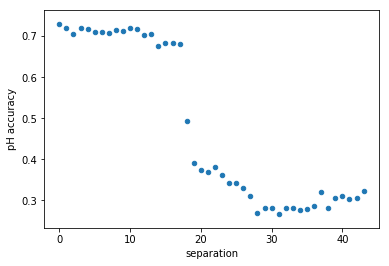

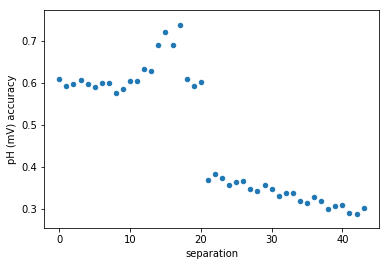

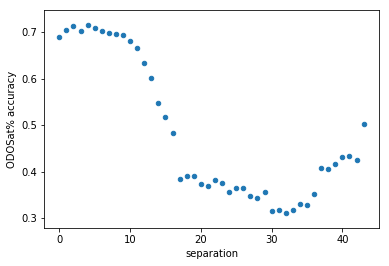

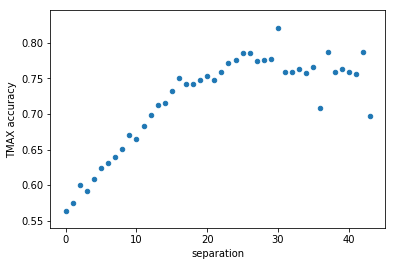

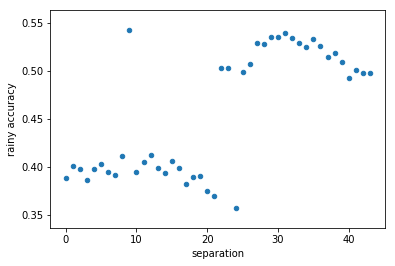

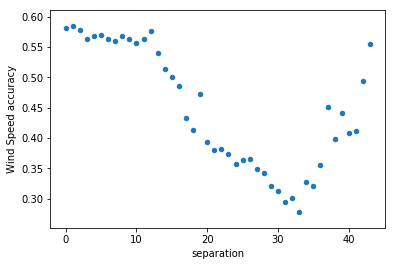

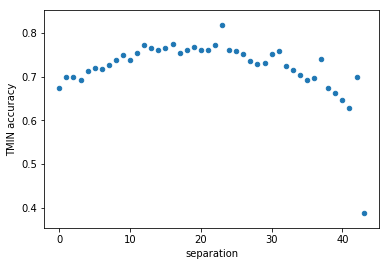

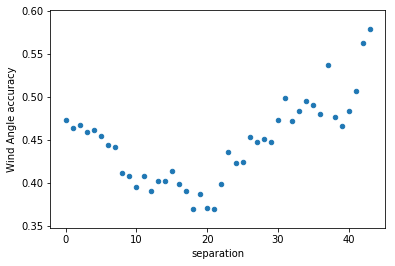

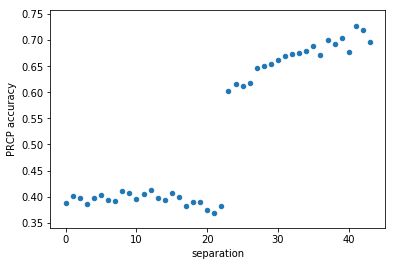

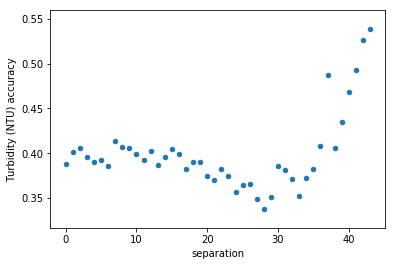

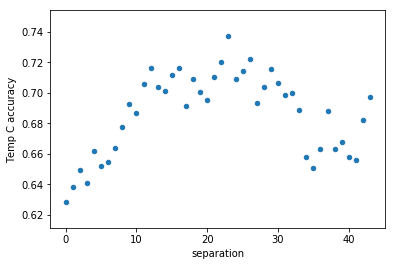

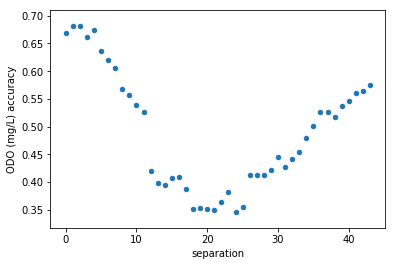

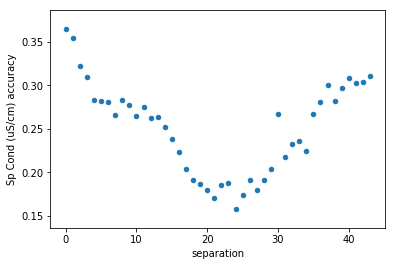

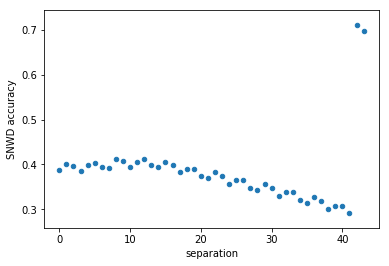

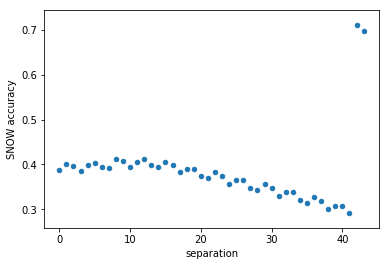

In [22]:
# Plot the accuracies vs separation size for each column
seps = [x.days for x in separations]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "separation": seps})
    df.plot(kind="scatter", y=col + " accuracy", x="separation")

## Greedy Custom Separation Size
Create a greedy model using the best custom separation sizes found above.

In [23]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, sep in best_sep.items():
    print(col, sep)
    parameters[col] = {'separation':sep, 'x_win_size':pd.Timedelta('7 days')}

# Windowize
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(train_dfs[0], 'datetime', 
                     target_column, custom_parameters=parameters)
train = train.append(hf.windowize(train_dfs[1], 'datetime', 
                     target_column, custom_parameters=parameters))
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(test_dfs[0], 'datetime', 
                    target_column, custom_parameters=parameters)
test = test.append(hf.windowize(test_dfs[1], 'datetime', 
                    target_column, custom_parameters=parameters))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

pH 0 days 00:00:00
pH (mV) 17 days 00:00:00
ODOSat% 4 days 00:00:00
TMAX 23 days 00:00:00
rainy 9 days 00:00:00
Wind Speed 1 days 00:00:00
TMIN 23 days 00:00:00
Wind Angle 0 days 00:00:00
PRCP 23 days 00:00:00
Turbidity (NTU) 7 days 00:00:00
Temp C 23 days 00:00:00
ODO (mg/L) 1 days 00:00:00
Sp Cond (uS/cm) 0 days 00:00:00
SNWD 12 days 00:00:00
SNOW 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: pH
Accuracy 0.7406779661016949
Recall: 0.8943089430894309
Precision 0.7432432432432432
Confusion Matrix:
 [[107 114]
 [ 39 330]]

Training model with: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37457627118644066
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [369   0]]

Training model with: Wind Angle
Accuracy 0.45084745762711864
Recall: 0.23306233062330622
Precision 0.6771653543307087
Confusion Matrix:
 [[180  41]
 [283  86]]

Training model with: PRCP
Accuracy 0.6016949152542372
Recall: 0.7560975609756098
Precision 0.6580188679245284
Confusion Matrix:
 [[ 76 145]
 [ 90 279]]

Training model with: Turbidity (NTU)
Accuracy 0.4406779661016949
Recall: 0.3956639566395664
Precision 0.5770750988142292
Confusion Matrix:
 [[114 107]
 [223 146]]

Training model with: Temp C
Accuracy 0.7372881355932204
Recall: 0.5880758807588076
Precision 0.9863636363636363
Confusion Matrix:
 [[218   3]
 [152 217]]

Training model with: ODO (mg/L)
Accuracy 0.688135593220339
Recall: 0.5474254742547425
Precision 0.9223744292237442
Confusion Matrix:
 [[204  17]
 [167 202]]

Training model with: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37457627118644066
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [369   0]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.2423728813559322
Recall: 0.07046070460704607
Precision 0.2
Confusion Matrix:
 [[117 104]
 [343  26]]

Training model with: TMIN
Accuracy 0.8186440677966101
Recall: 0.7940379403794038
Precision 0.904320987654321
Confusion Matrix:
 [[190  31]
 [ 76 293]]

Training model with: rainy
Accuracy 0.5033898305084745
Recall: 0.5203252032520326
Precision 0.6233766233766234
Confusion Matrix:
 [[105 116]
 [177 192]]

TMIN metric value: 0.8186440677966101
TMAX metric value: 0.7711864406779662
ODOSat% metric value: 0.7457627118644068
pH metric value: 0.7406779661016949
Temp C metric value: 0.7372881355932204
ODO (mg/L) metric value: 0.688135593220339
Wind Speed metric value: 0.6033898305084746
PRCP metric value: 0.6016949152542372
pH (mV) metric value: 0.5389830508474577
rainy metric value: 0.5033898305084745
Wind Angle metric value: 0.45084745762711864
Tur

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'ODOSat%', 'pH', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH (mV)', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'ODOSat%', 'pH', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH (mV)', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8186440677966101
Test model recall: 0.7940379403794038
Test model precision: 0.904320987654321

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.8084745762711865
Test model recall: 0.7317073170731707
Test model precision: 0.9507042253521126

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7677966101694915
Test model recall: 0.6558265582655827
Test model precision: 0.9603174603174603

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7542372881355932
Test model recall: 0.8997289972899729
T

In [26]:
# Cross validate
base_columns = ['TMIN']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

accuracy 0.6539855072463768
recall 0.896414342629482
precision 0.5769230769230769

